In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image


# Read In Data
## Setting Standard
Throughout this project:
- 0 corresponds to not wearing a mask
- 1 corresponds to wearing a mask

In [4]:
# make directory to save generated images to
os.makedirs('img', exist_ok=True)

dataset_dir = os.path.join("datasets", "face_mask")
def get_dataset_fn(dataset_dir: str, type: str) -> (np.array, np.array):
    """
    given the directory name of the entire dataset and whether it is the train, validation, or test set
    return X and y where X is a list of filenames and y is the target labels
    """
    # get base dir path (account for different operating systems)
    base_dir = os.path.join(dataset_dir, type)
    # get directories for each class in each folder
    no_mask_dir = os.path.join(base_dir, "WithoutMask")
    mask_dir = os.path.join(base_dir, "WithMask")
    # get filenames
    no_mask_fn = list(map(lambda fn: os.path.join(no_mask_dir,fn),os.listdir(no_mask_dir)))
    mask_fn = list(map(lambda fn: os.path.join(mask_dir,fn), os.listdir(mask_dir)))
    # create X with associated y labels
    y = np.hstack((np.zeros(len(no_mask_fn)),np.ones(len(mask_fn))))
    X = np.hstack((np.array(no_mask_fn),np.array(mask_fn)))
    return X, y

# get dataset of filenames and labels
X_train_fn, y_train = get_dataset_fn(dataset_dir, "train")
X_validation_fn, y_validation = get_dataset_fn(dataset_dir, "validation")
X_test_fn, y_test = get_dataset_fn(dataset_dir, "test")

def load_img(fn: str) -> np.array:
    """
    load an image into a numpy array from the given filename
    """
    return image.imread(fn)

def load_dataset(X_fn: np.array) -> list:
    """
    given a list of filenames, load in each image into a numpy array and return a list of the images
    """
    X = []
    # iterate through each filename and load in each image
    for i in range(len(X_fn)):
        X.append(load_img(X_fn[i]))

    # returns X as a list because images are different sizes
    return X

def show_img(ax, img: np.array, label=None):
    ax.axis("off")
    ax.imshow(img)
    # plt.show()

X_train = load_dataset(X_train_fn)


## Peek at Dataset
In order to get a feel for the data, lets look at some of the images

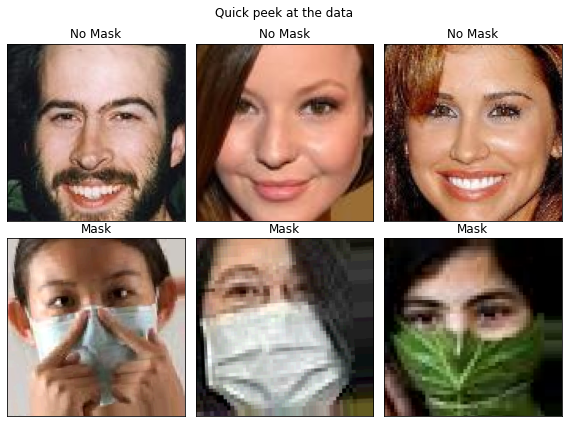

In [5]:
def plot_img_grid(img, label, size, pos):
    """
    given the image, its label, the size of the grid, and its position on the grid,
    create a grid of images displaying images in the dataset
    """
    ax = plt.subplot2grid(size, pos)
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    ax.title.set_text(label)
    ax.imshow(img)

fig = plt.figure(figsize=(8,6))
fig.suptitle('Quick peek at the data')
plot_img_grid(X_train[0], 'No Mask', (2,3),(0,0))
plot_img_grid(X_train[1000], 'No Mask', (2,3),(0,1))
plot_img_grid(X_train[2000], 'No Mask', (2,3),(0,2))
plot_img_grid(X_train[7000], 'Mask', (2,3),(1,0))
plot_img_grid(X_train[8001], 'Mask', (2,3),(1,1))
plot_img_grid(X_train[9004], 'Mask', (2,3),(1,2))
plt.tight_layout()
plt.savefig('./img/faces.png', dpi=500)
plt.show()
